## Problem 0: Implementation of Forces and Moments
Implement the `forces_moments`, `motor_thrust_torque`, and `update_velocity_data` functions in `chap4/mav_dynamics.py` as described in chapter 4. 

Below are some useful code snippets and hints:
* R = Quaternion2Rotation(self._state[IND.QUAT]) # computes the rotation from body to world frame
* uvw = state[IND.VEL] # Extracts the u-v-w body axis velocities from the state vector
* MAV contains the UAV parameters (i.e., MAV.mass gives the mass and MAV.gravity is the gravity constant)
* In `forces_moments`, you will need to calculate the following:
  * gravitaional forces
  * Lift and Drag coefficients
  * Lift and Drag Forces
  * longitudinal forces and torques
  * lateral forces and torques
* In `motor_thrust_torque` you will do the following
  * Use the quadratic formulate to solve for motor speed
  * Use the resulting values to compute the angular speed of the propeller
  * Compute and return the thruse and torque due to the propeller
* In `update_velocity_data` you will do the following
  * Convert the wind vector to the body frame
  * Compute the airspeed
  * Compute the angle of attack
  * Compute the sideslip angle

Running the simulator requires passing a function that takes in a time value and produces a command. We'll learn about trim later, but trim trajectories are trajectories that can be flown with constant inputs. In reality the trim inputs can only be used for a small amount of time without any feedback due to disturbances. Once implemented, the following code will produce a trajectory that flights straight and steady without any need for modification.

In [1]:
# Note that this cell can be run separately to initialize for other cell blocks
import numpy as np
from mav_sim.chap3.mav_dynamics import DynamicState
from mav_sim.chap4.run_sim import run_sim
from mav_sim.message_types.msg_delta import MsgDelta
from mav_sim.message_types.msg_sim_params import MsgSimParams
from mav_sim.message_types.msg_gust_params import MsgGustParams
from mav_sim.tools.display_figures import display_data_view, display_mav_view
from mav_sim.chap2.mav_viewer import MavViewer
from mav_sim.chap3.data_viewer import DataViewer

# The viewers need to be initialized once due to restart issues with qtgraph
if 'mav_view' not in globals():
    print("Initializing mav_view")
    global mav_view
    mav_view = MavViewer()  # initialize the mav viewer
if 'data_view' not in globals():
    print("Initializing data_view")
    global data_view
    data_view = DataViewer()  # initialize view of data plots

# Initialize state values
sim_params = MsgSimParams(end_time=40., video_name="chap4.avi") # Sim ending in 10 seconds
state = DynamicState()

# Functions used below
def run_sim_and_display(delta_fnc, use_wind = False, gust_params = None):
    global mav_view
    global data_view
    data_view.reset(sim_params.start_time)
    (mav_view, data_view) = run_sim(sim_params, delta_fnc, state, mav_view, data_view, use_wind, gust_params)
    display_data_view(data_view)
    display_mav_view(mav_view)

def trim(time: float)->MsgDelta:
    """Passes out the constant trim command
    """
    # Set control surfaces
    delta = MsgDelta()
    delta.elevator = -0.1248
    delta.aileron = 0.001836
    delta.rudder = -0.0003026
    delta.throttle = 0.6768
    return delta

Initializing mav_view
Initializing data_view


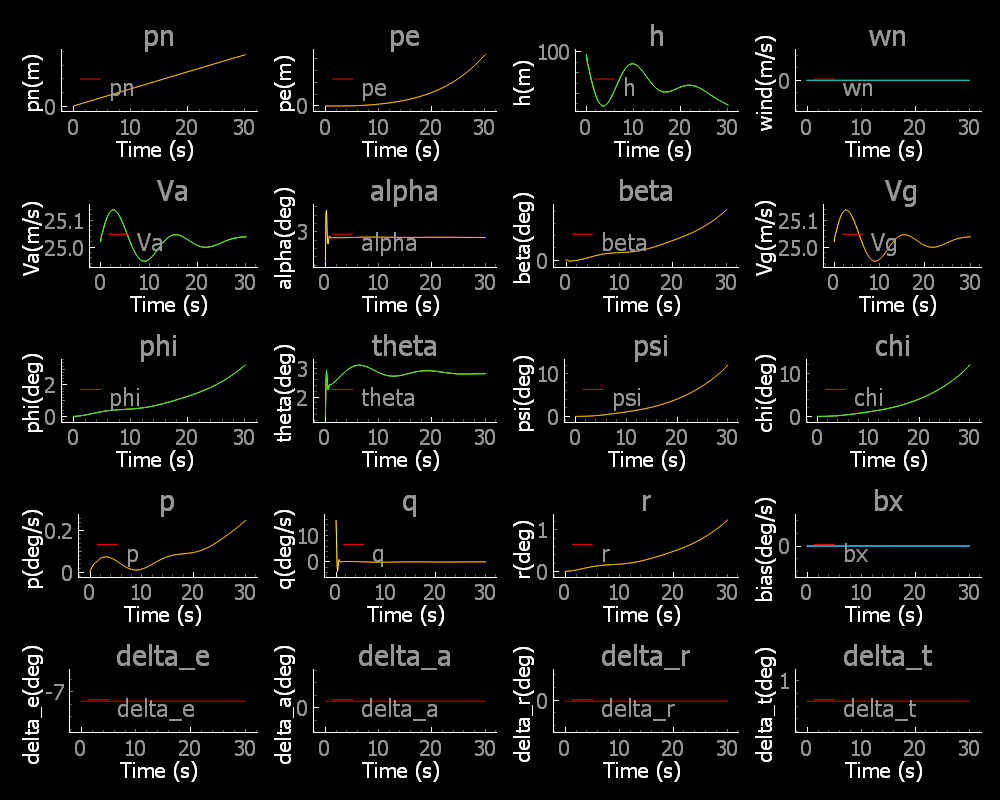

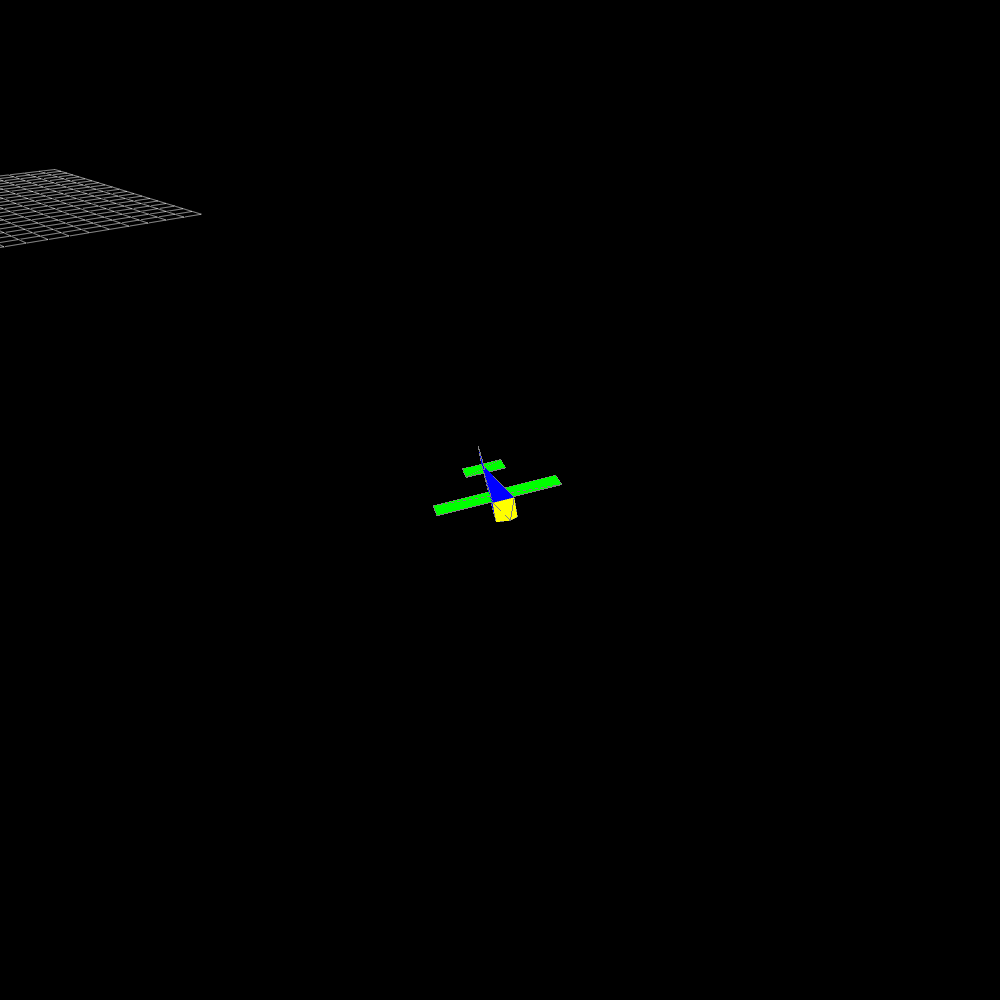

In [2]:
# Run a "straight" trim trajectory
run_sim_and_display(trim)

## Problem 1: Effect of the elevator control surface
This problem varies the elevator value during flight of the aircraft. Design a function that will perturb the elevator control surface by 5 degrees in the negative direction after 5 seconds and 5 degrees in the positive direction after 15 seconds.

### Question: Given the definitions of positive control surface deflection from chapter 4, what behavior do you expect for the altitude, Y-axis angular velocity, airspeed, and pitch angle?
**Answer:** A negative value for $\delta_e$ will cause a nose up pitch moment (i.e., positive about $j^b$ axis). This moment will cause a positive perturbation to the y-axis angular velocity, $q$, and an increase in pitch. A decrease in $\delta_e$ will cause both an increase in $F_{lift}$ and $F_{drag}$, causing the aircraft to temporarily increase altitude and decrease speed. The opposite will is true for the positive perturbation, although the effects will not be as prominent due to the prior disturbances of the aircraft.

(Insert before simulation)

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** (Up to individual)

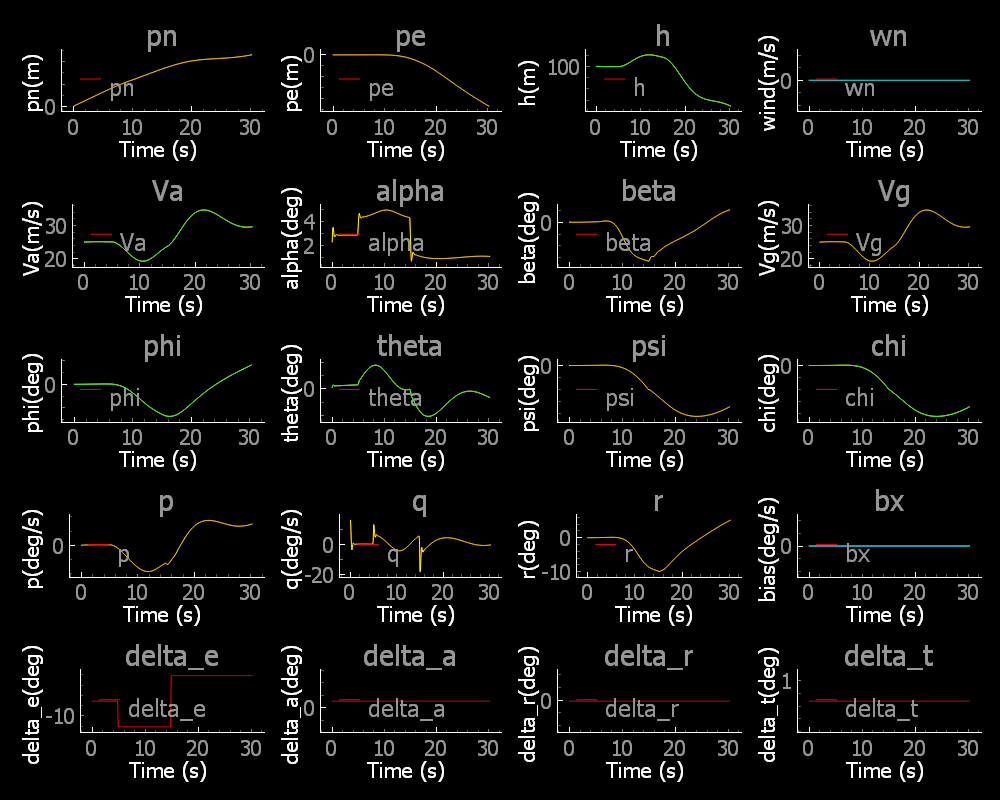

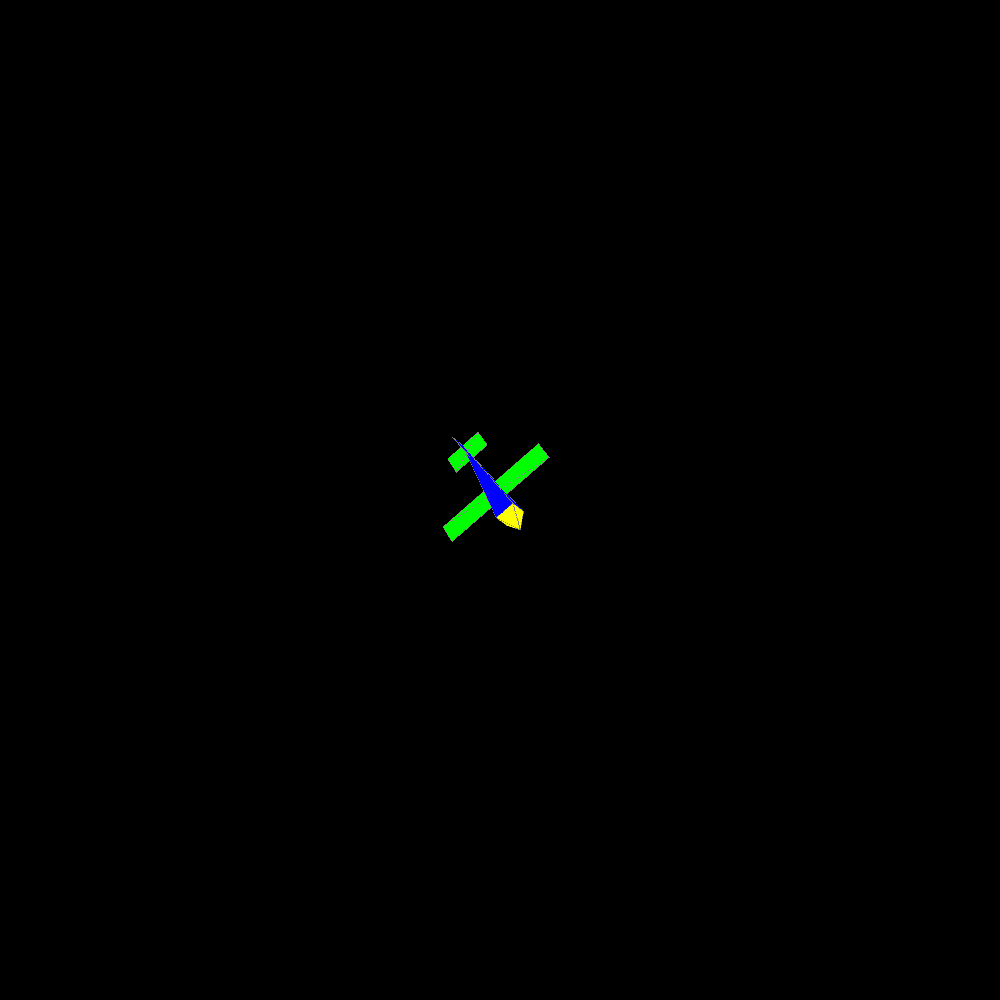

In [3]:
def perturb_elevator(time: float) -> MsgDelta:
    """ Perturb the elevator trim commands by
            -5 degrees      5 < time <= 15
            5  degrees      15 < time
    """
    delta = trim(time)
    if time > 15.:
        delta.elevator += 5*np.pi/180. # Perturb up by 5 degrees
    elif time > 5:
        delta.elevator += -5*np.pi/180. # Perturb down by 5 degrees
    return delta

# Perturb the elevator
run_sim_and_display(perturb_elevator)

## Problem 2: Effect of the aileron control surface
This problem varies the aileron value during flight of the aircraft.  Design a function that will perturb the aileron control surface by 0.2 degrees in the negative direction after 5 seconds and 0.2 degrees in the positive direction after 15 seconds.

### Question: Given the definitions of positive control surface deflection from chapter 4, what behavior do you expect for X-axis angular velocity, roll angle, and heading?
**Answer:** A negative value for $\delta_a$ will cause a right-wing up roll momement (i.e., negative about $i^b$). This will cause a negative value for the x-axis angular velocity, $p$, and reduce the roll angle. A yawing moment will be induced and effect the value of $\psi$. The opposite will is true for the positive perturbation, although the effects will not be as prominent due to the prior disturbances of the aircraft.

(Insert before simulation)

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** (Up to individual)

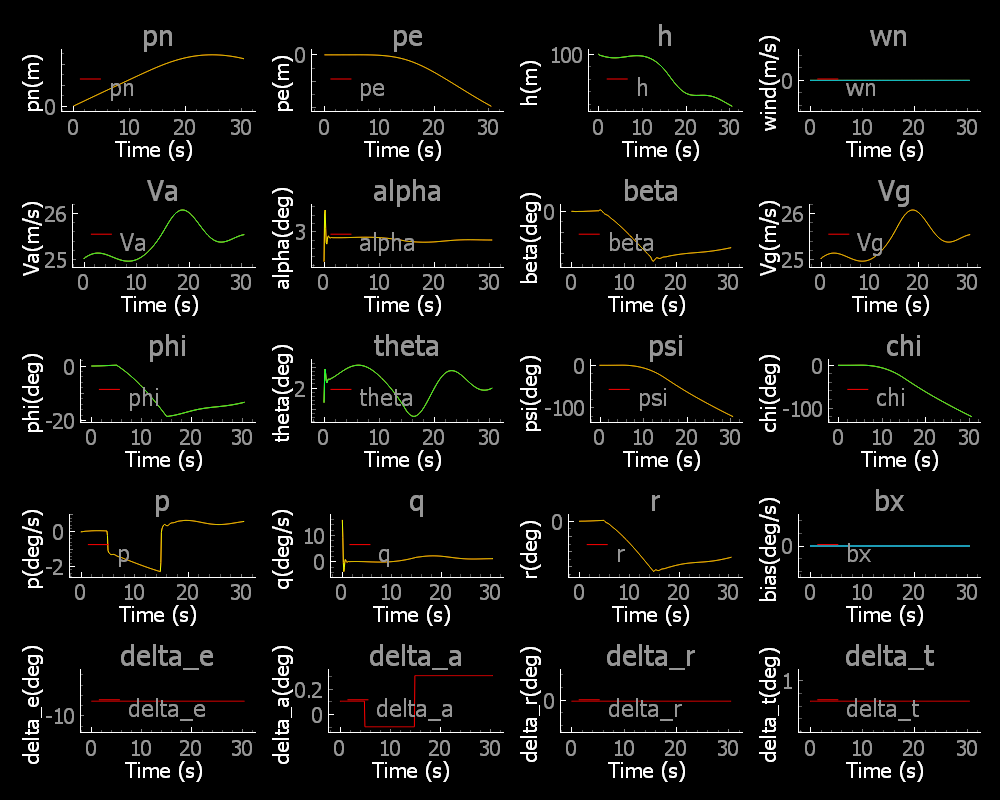

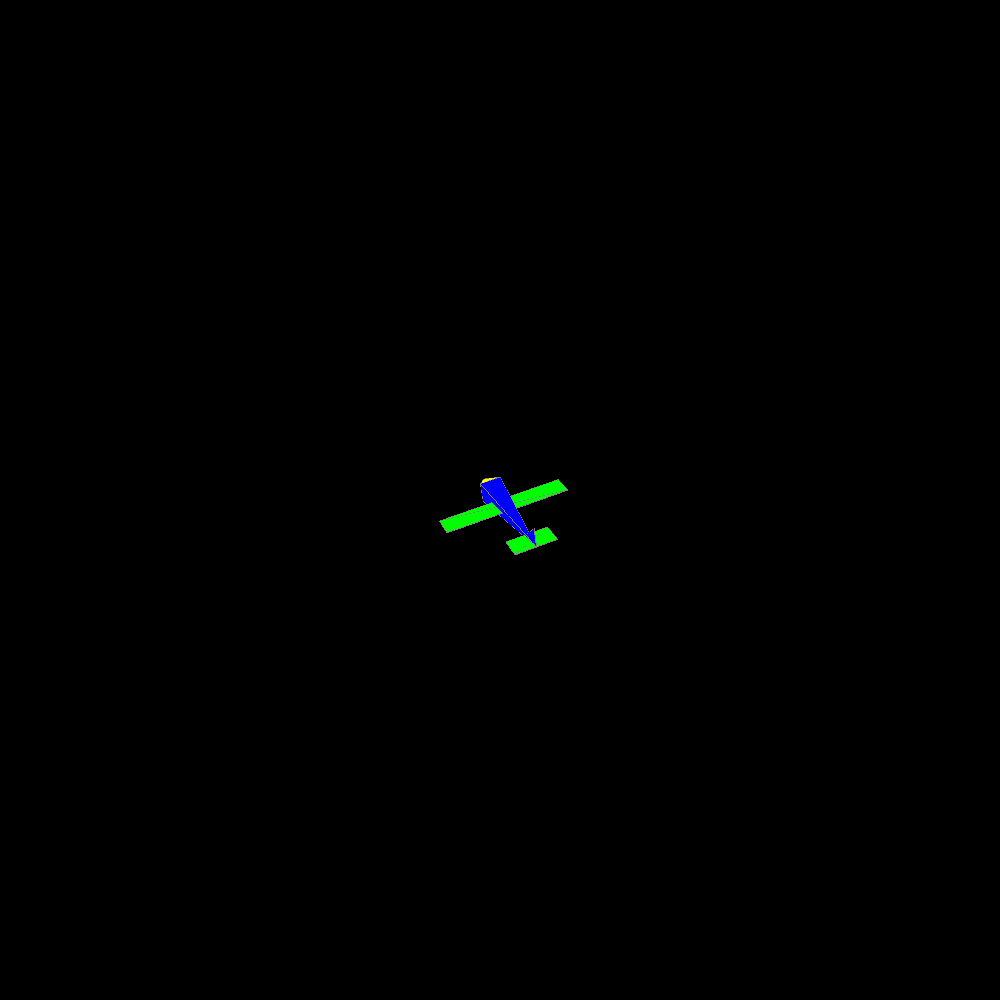

In [4]:
def perturb_aileron(time: float) -> MsgDelta:
    """ Perturb the aileron trim commands by
            -0.2 degrees      5 < time <= 15
            0.2  degrees      15 < time
    """
    delta = trim(time)
    if time > 15.:
        delta.aileron += 0.2*np.pi/180. # Perturb up by 0.2 degrees
    elif time > 5:
        delta.aileron += -0.2*np.pi/180. # Perturb down by 0.2 degrees
    return delta

# Perturb the elevator
run_sim_and_display(perturb_aileron)

## Problem 3: Effect of the rudder control surface
This problem varies the rudder value during flight of the aircraft.  Design a function that will perturb the rudder control surface by 0.2 degrees in the negative direction after 5 seconds and 0.2 degrees in the positive direction after 15 seconds.

### Question: Given the definitions of positive control surface deflection from chapter 4, what behavior do you expect for Z-axis angular velocity, heading angle, and roll angle?
**Answer:** A negative value for $\delta_r$ will primarily cause a nose-right yaw (positive torque about $k^b$). This torque will cause an increase in yaw rate, $r$, which will in turn cause $\psi$ to increase. A secondary effect will be to induce a roll moment. The opposite will is true for the positive perturbation, although the effects will not be as prominent due to the prior disturbances of the aircraft.

(Insert before simulation)

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** (Up to individual)

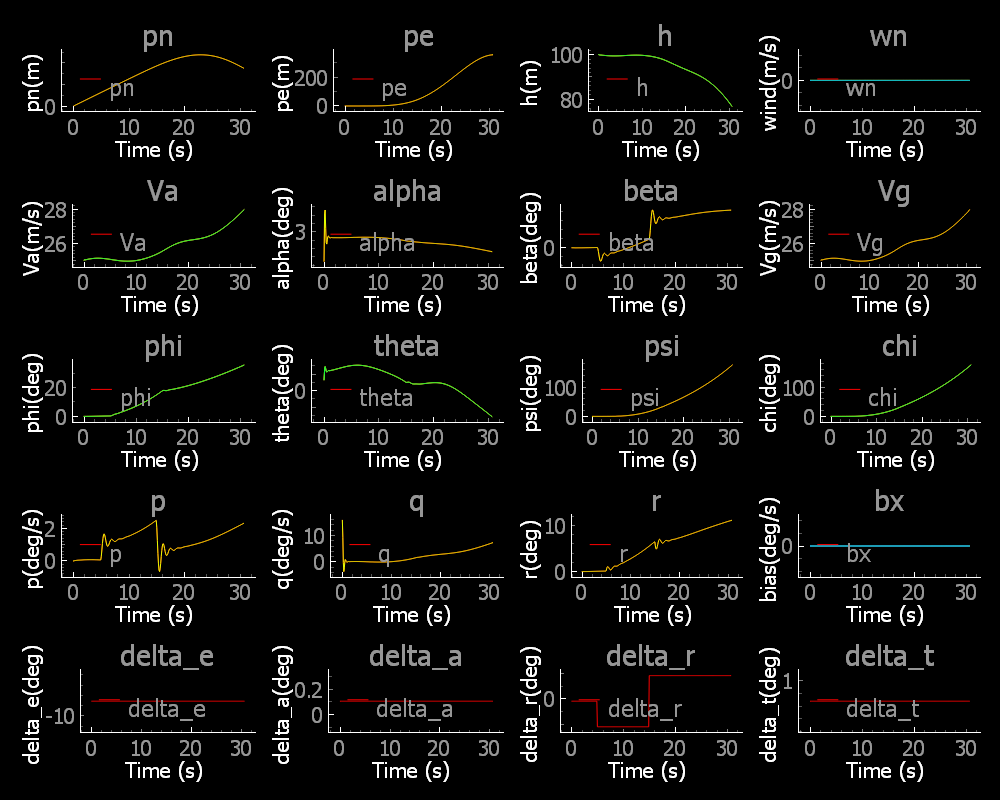

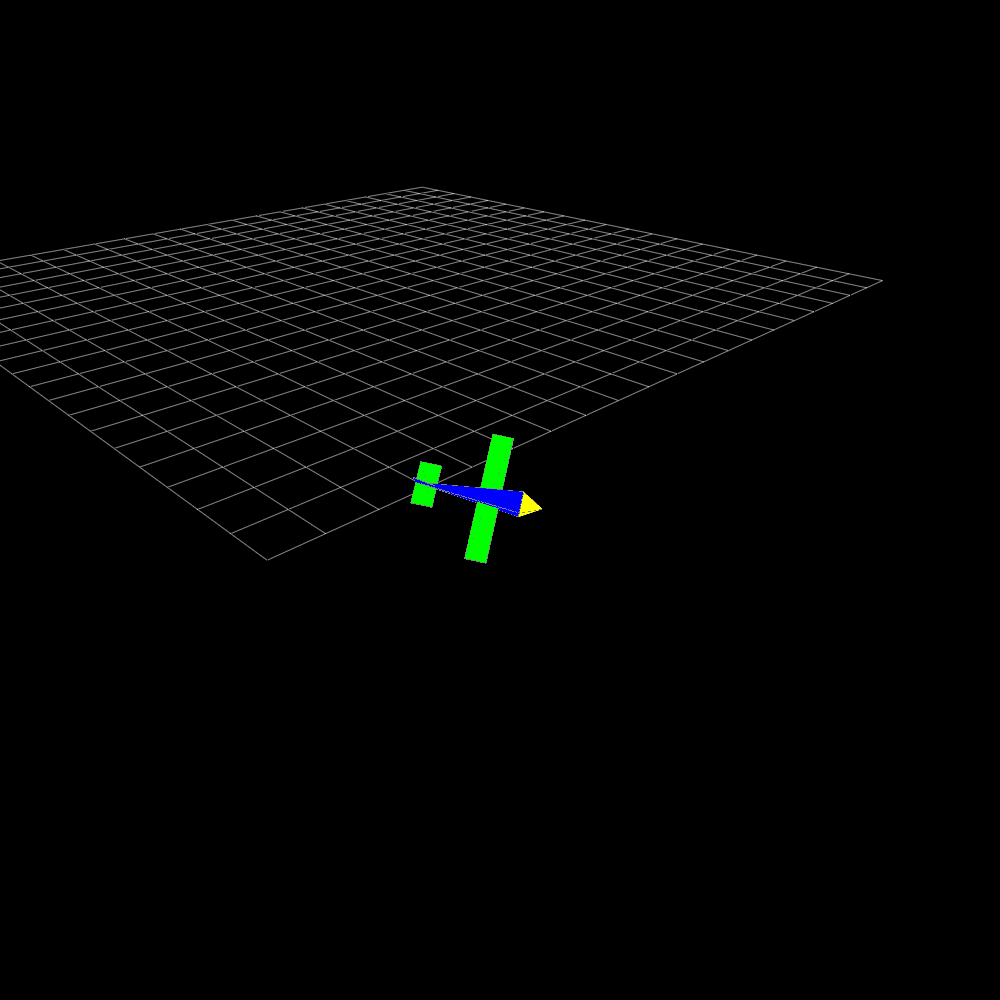

In [5]:
def perturb_rudder(time: float) -> MsgDelta:
    """ Perturb the rudder trim commands by
            -0.2 degrees      5 < time <= 15
            0.2  degrees      5 < time
    """
    delta = trim(time)
    if time > 15.:
        delta.rudder += 0.2*np.pi/180. # Perturb up by 0.2 degrees
    elif time > 5:
        delta.rudder += -0.2*np.pi/180. # Perturb down by 0.2 degrees
    return delta

# Perturb the elevator
run_sim_and_display(perturb_rudder)

## Problem 4: Effect of the throttle control input
This problem varies the throttle value during flight of the aircraft.  Design a function that will perturb the throttle by 0.2 in the negative direction after 5 seconds and 0.2 in the positive direction after 15 seconds.

### Question: Given the definitions of positive thrust from chapter 4, what behavior do you expect for airspeed,  altitude, and roll rates?
**Answer:** There should be an immediate deceleration in the forward direction. This will most directly affect $V_a$, causing it to decrease. The reduction in $V_a$ will cause a loss of lift which will in turn cause the altitude to drop. Reducing the speed of the prop/motor will also cause a slight change in the roll torque, but the restorative nature of the roll static stability derivative may counteract the response and so only a small disturbance in roll rate will be noticed. The opposite will is true for the positive perturbation, although the effects will not be as prominent due to the prior disturbances of the aircraft.

(Insert before simulation)

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** (Up to individual)

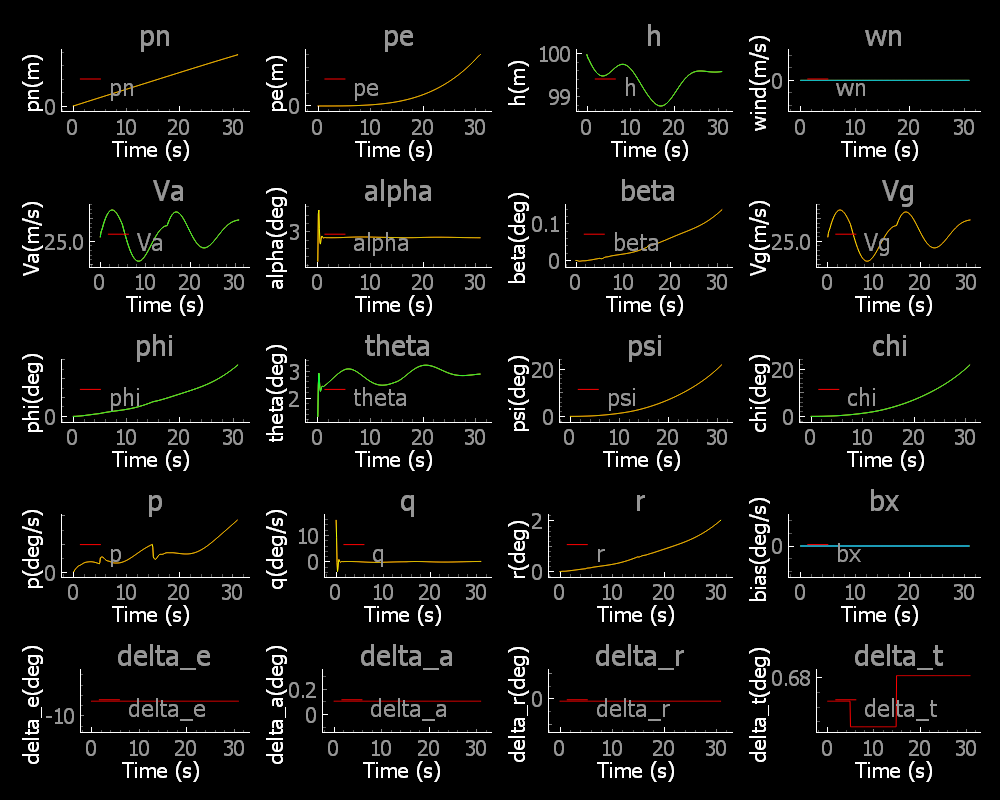

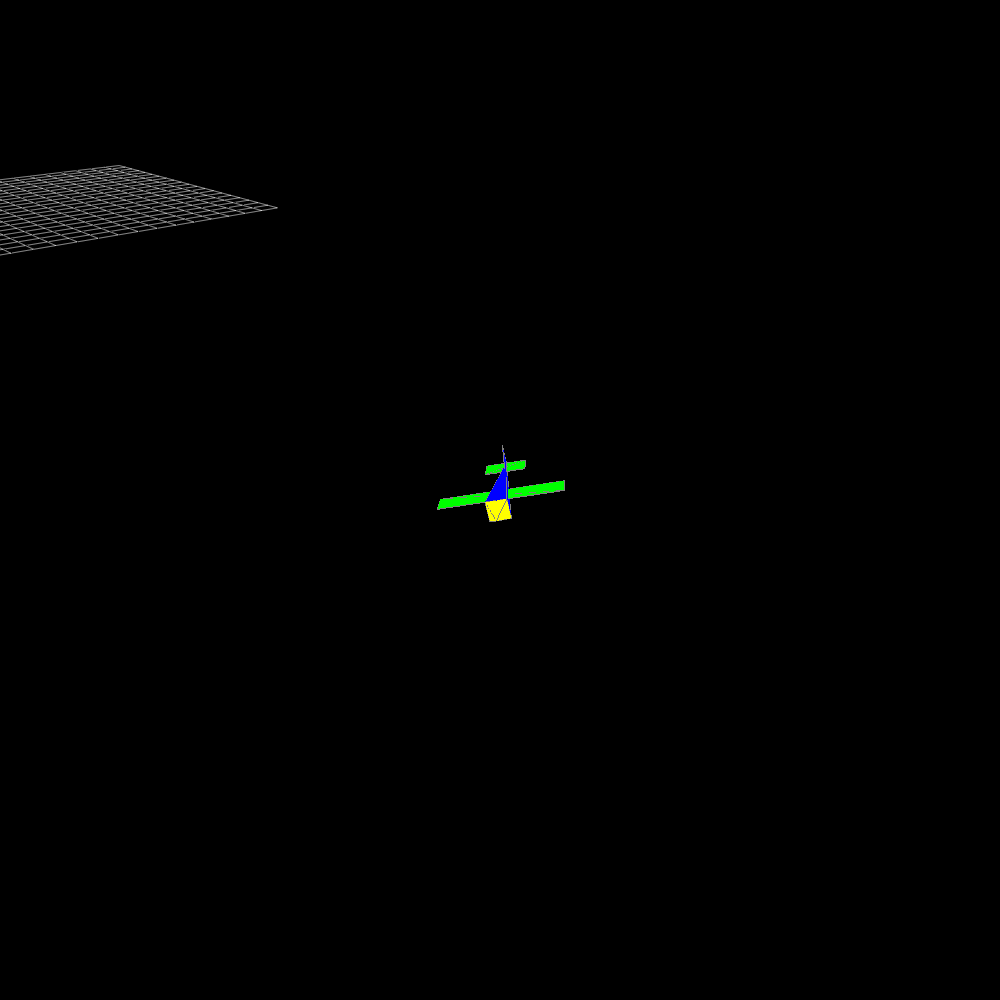

In [6]:
def perturb_throttle(time: float) -> MsgDelta:
    """ Perturb the throttle trim commands by
            -0.2       5 < time <= 15
            0.2        5 < time
    """
    delta = trim(time)
    if time > 15.:
        delta.throttle += 0.2*np.pi/180. # Perturb up by 0.2
    elif time > 5:
        delta.throttle += -0.2*np.pi/180. # Perturb down by 0.2
    return delta

# Perturb the elevator
run_sim_and_display(perturb_throttle)

## Problem 5: Wind model implementation
The previous problems did not consider wind. You will now implement the Dryden gust model as defined in Chapter 4.4 of the book. Namely, you will implement the transfer functions in the `__init__` function of `wind_siumulation.py`. 

For example, the parameter *self.u_w* is a transfer function of the form
$$
    H_u(s) = \sigma_u \sqrt{\frac{2V_a}{L_u}} \frac{1}{s+\frac{V_a}{L_u}}
$$
This results in a transfer function with the numerator and denominator defined as
$$
numerator = \sigma_u \sqrt{\frac{2V_a}{L_u}}
$$
$$
denominator = s+\frac{V_a}{L_u}
$$
The numerators and denominators are passed into a `TransferFunction` class that is provided to you by specifying their coefficients. The above equation for $H_u(s)$ can be implemented as follows:
```
a1 = sigma_u*np.sqrt(2.*Va/Lu)
b1 = Va/Lu
self.u_w = TransferFunction(num=np.array([[a1]]),
                            den=np.array([[1, b1]]),
                            Ts=Ts)
```
In `wind_siumulation.py`, you will initialize the following
* `self.u_w` is the transfer function $H_u(s)$
* `self.v_w` is the transfer function $H_v(s)$
* `self.w_w` is the transfer function $H_w(s)$

## Problem 6: Using non-zero wind parameters
You will now run the simulation with a set of parameters for the Dresden gust model from Table 4.1 of the book. Use the medium altitude, moderate turbulence model parameters.

### Question: What effects do you expect to see on the states for the medium altitude, moderate turbulence model as compared to the results of Problem 0?
**Answer:** The main effect is noise added into the system. This noise causes random forces and moments to enter into the dynamics, causing the UAV to perform slightly more erratically. 


Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** (Up to individual)

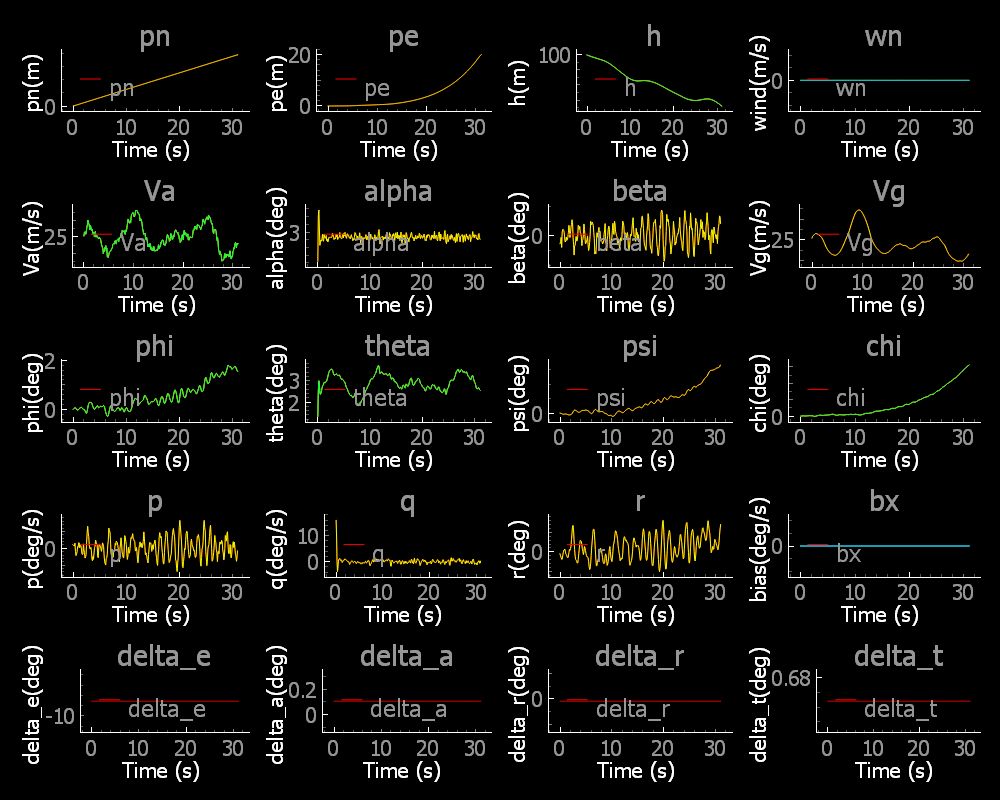

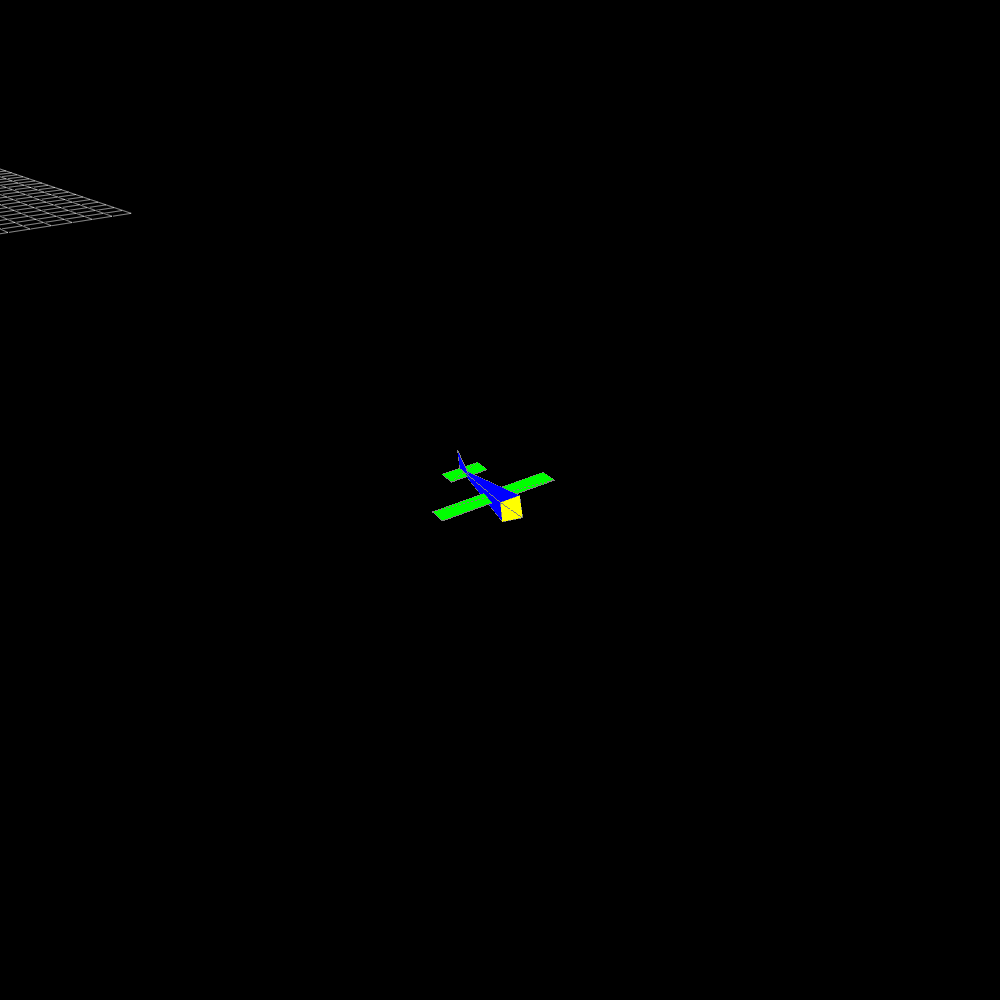

In [7]:
# Run a "straight" trim trajectory with medium altitude, moderate turbulence
gust_params = MsgGustParams()
gust_params.sigma_u = 3
gust_params.sigma_v = 3
gust_params.sigma_w = 3
gust_params.Lu = 533
gust_params.Lv = 533
gust_params.Lw = 533
run_sim_and_display(trim, use_wind=True, gust_params=gust_params)